# 概要
手書き数字データ（[EMNIST](https://www.nist.gov/itl/iad/image-group/emnist-dataset)）の潜在変数を獲得する。  
### ～ポイント～ 
数字ラベルを利用することで、
1. 数字の識別に寄与する潜在変数
2. 数字の識別に無関係な潜在変数
に分離することを目指す。


# Abstract
My goal is to obtain latent variable from hand-written digit datasets(EMNIST).
### ~Points~
Usinig digit labels, decompose latent variable to following two parts.
1. Latent Variable which contribute to classify digit labels.
2. Latent Variable which is irrelevant to classify digit labels. 

## 1. EMNISTの読み込み
EMNISTは[ここ](http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip)からダウンロード可能です。

## 1. Load EMNIST Dataset
EMNIST Dataset is available [here](http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip)!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from scipy.io import loadmat
import six

%matplotlib inline


def visualize(images):
    n_images = images.shape[0]
    fig = plt.figure(figsize=(n_images, 1.4))
    gs = gridspec.GridSpec(1, n_images, wspace=0.1, hspace=0.1)

    for i in range(n_images):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(images[i].reshape(28, 28).transpose(1, 0), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    gs.tight_layout(fig)

In [2]:
dataset = loadmat('../matlab/emnist-digits.mat')['dataset']

array([8, 9, 6, 3, 6, 6, 7, 1, 9, 0], dtype=uint8)

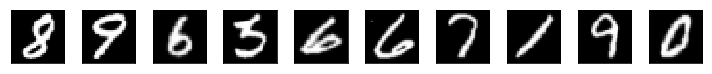

In [3]:
tmp_img = dataset[0][0][0][0][0][0][0:10]
visualize(tmp_img)
dataset[0][0][0][0][0][1][0:10].flatten()

In [4]:
train_img = dataset[0][0][0][0][0][0].astype(np.float32)/255
train_labels = dataset[0][0][0][0][0][1].flatten().astype(np.int32)
train_writers = dataset[0][0][0][0][0][2].flatten()

test_img = dataset[0][0][1][0][0][0].astype(np.float32)/255
test_labels = dataset[0][0][1][0][0][1].flatten().astype(np.int32)
test_writers = dataset[0][0][1][0][0][2].flatten()

In [5]:
x_train, x_test = train_img, test_img
y_train, y_test = train_labels, test_labels
N_test = y_test.size
N = len(x_train)

## 2. 筆者ラベルの再インデクシング
## 2. Reindex Writer IDs

In [6]:
import numpy as np
x = np.array(train_writers)
y = np.bincount(x)
ii = np.nonzero(y)[0]

In [7]:
df_writers = pd.DataFrame(np.unique(train_writers))

In [8]:
writers = np.unique(train_writers)
writers = pd.DataFrame(writers, columns=['truth'])
writers['i'] = writers.index
df = pd.DataFrame({'writer': train_writers})
df = pd.merge(df, writers, left_on='writer', right_on='truth', how='left')
train_writers = df.i.values

# writers = np.unique(test_writers)
# writers = pd.DataFrame(writers, columns=['truth'])
# writers['i'] = writers.index
df = pd.DataFrame({'writer': test_writers})
df = pd.merge(df, writers, left_on='writer', right_on='truth', how='left')
test_writers = df.i.values

## 3. 可視化とモデル保存のための関数
## 3. Function for VIsualization and Save models

### Visualize Functions

In [9]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence
from chainer import Variable
from chainer import cuda
from chainer import optimizers
from chainer import serializers
n_labels = 10

In [10]:
def visuaiize_reconstructed_image(model):
    model.to_cpu()
    x = Variable(np.array(x_test[0:10]))
    visualize((x.data*255).astype(np.int16))
    visualize((model(x).data*255).astype(np.int16))

    
def visualize_latent_space(model):
    model.to_cpu()

    # pick writer who has many data
    df = pd.DataFrame({'writer': test_writers})
    idx = df.writer.value_counts()
    idx = idx.sort_values(ascending=False).head(10000).index.values
    mask = np.in1d(test_writers, idx)
    tmp_test_img = test_img[mask]
    tmp_test_labels = test_labels[mask]
    tmp_test_writers = test_writers[mask]

    mu_a, sigma_a, mu_b, sigma_b = model.encode(Variable(tmp_test_img))

    df_z = pd.DataFrame({'za': mu_a.array.flatten(), 'zb': mu_b.array.flatten(),
                         'digit': tmp_test_labels, 'writer': tmp_test_writers})

    fig = plt.figure(figsize=[16, 6])
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    df_z.plot.scatter(x='za', y='zb', c='digit', cmap='jet', 
                      ax=ax1, title='Latent Space (Colored by digits)')
    df_z.plot.scatter(x='za', y='zb', c='writer', cmap='jet', 
                      ax=ax2, title='Latent Space (Colored by writers)')

    
def visuaiize_reconstruct_space(model):
    model.to_cpu()

    A = np.arange(-4, 4, 0.15)
    B = np.arange(4, -4, -0.5)

    ab = np.array([[a, b] for b in B for a in A], dtype=np.float32)

    x_hat = model.decode(Variable(ab[:, 0].reshape(-1, 1)),
                         Variable(ab[:, 1].reshape(-1, 1)), True)

    images = x_hat.data.reshape(-1, 28, 28)
    images = images.transpose(0, 2, 1)

    img_h = images.shape[1]
    img_w = images.shape[2]
    w_plots = len(A)
    h_plots = len(B)

    spriteimage = np.ones((img_h * h_plots, img_w * w_plots))

    for i in range(h_plots):
        for j in range(w_plots):
            this_filter = i * w_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i*img_h:(i+1)*img_h, j*img_w:(j+1)*img_w] = this_img

    fig = plt.figure(figsize=[16, 12])
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2, 
                          title='Reconstructed image (position consistent)')

    ax2.imshow(spriteimage, cmap='gray', interpolation='nearest')
    
    df = pd.DataFrame({'writer': test_writers})
    idx = df.writer.value_counts().sort_values(ascending=False).head(1000).index.values
    mask = np.in1d(test_writers, idx)
    tmp_test_img = test_img[mask]
    tmp_test_labels = test_labels[mask]
    tmp_test_writers = test_writers[mask]
    mu_a, sigma_a, mu_b, sigma_b = model.encode(Variable(tmp_test_img))

    df_z = pd.DataFrame({'za': mu_a.array.flatten(), 'zb': mu_b.array.flatten(),
                         'digit': tmp_test_labels, 'writer': tmp_test_writers})
    df_z.plot.scatter(x='za', y='zb', c='digit', cmap='jet', alpha=0.7, ax=ax1,
                      colorbar=False, title='Latent Space (Colored by digits)')
    
    
def visualize_all(model):
    visuaiize_reconstructed_image(model)
    visualize_latent_space(model)
    visuaiize_reconstruct_space(model)


### Save Model Function

In [11]:
def save_model(model, name, data):
    from chainer import serializers
    import json
    from datetime import datetime
    
    serializers.save_npz('model/'+str(name)+'.model', model)

    data['date'] = str(datetime.now())
    with open('model/'+str(name)+'.txt', 'w') as outfile:
        json.dump(data, outfile)

### HyperParameters

In [12]:
batchsize = 256
n_epoch = 50
n_latent = 1
n_hidden = 500

C1 = 1
C2 = 10000
C3 = 10000

## 4. ダブルボトルネック変分自己符号化器 + 識別器
## 4. Double Latent Variational AutoEncoder + Classification(softmax)

In [13]:
class WVAE_CLF(chainer.Chain):
    """Variational AutoEncoder"""

    def __init__(self, n_in=784, n_latent=20, n_h=500):
        super(WVAE_CLF, self).__init__()
        with self.init_scope():
            # encoder
            self.le1 = L.Linear(n_in, n_h)
            
            self.le2_mu_a = L.Linear(n_h, n_latent)
            self.le2_ln_var_a = L.Linear(n_h, n_latent)
            
            self.le2_mu_b = L.Linear(n_h, n_latent)
            self.le2_ln_var_b = L.Linear(n_h, n_latent)
            # decoder
            self.ld1_a = L.Linear(n_latent, n_h)
            self.ld1_b = L.Linear(n_latent, n_h)
            
            self.l_c = L.Linear(n_latent, n_labels)
            
            self.ld2 = L.Linear(n_h, n_in)

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        mu_a, sigma_a, mu_b, sigma_b = self.encode(x)
        return self.decode(mu_a, mu_b, sigmoid)
    
    def encode(self, x):
        h1 = F.tanh(self.le1(x))
        
        mu_a = self.le2_mu_a(h1)
        ln_var_a = self.le2_ln_var_a(h1)  # log(sigma**2)
        
        mu_b = self.le2_mu_b(h1)
        ln_var_b = self.le2_ln_var_b(h1)  # log(sigma**2)
        return mu_a, ln_var_a, mu_b, ln_var_b

    def decode(self, z_a, z_b, sigmoid=True):
        h1 = F.tanh(self.ld1_a(z_a)) + F.tanh(self.ld1_b(z_b))
        h2 = self.ld2(h1)
        if sigmoid:
            return F.sigmoid(h2)
        else:
            return h2

    def get_loss_func(self, C1=1.0, C2=100.0, k=1):
        """Get loss function of VAE.
        The loss value is equal to ELBO (Evidence Lower Bound)
        multiplied by -1.
        Args:
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
        """
        def lf(args):
            x, t = args
            mu_a, ln_var_a, mu_b, ln_var_b = self.encode(x)
            batchsize = len(mu_a.data)
            # reconstruction loss
            rec_loss = 0
            clf_loss = 0
            for l in six.moves.range(k):
                z_a = F.gaussian(mu_a, ln_var_a)
                z_b = F.gaussian(mu_b, ln_var_b)
                rec_loss += F.bernoulli_nll(x, self.decode(z_a, z_b, sigmoid=False)) \
                    / (k * batchsize)
                clf_loss += C2 * F.softmax_cross_entropy(self.l_c(z_a), t) \
                    / (k * batchsize)
            self.rec_loss = rec_loss
            self.clf_loss = clf_loss
            self.loss = self.rec_loss + self.clf_loss +  \
                C1 * (gaussian_kl_divergence(mu_a, ln_var_a) + 
                      gaussian_kl_divergence(mu_b, ln_var_b)) / batchsize
                
            return self.loss
        return lf

In [14]:
print('# dim z: {}'.format(n_latent))
print('# Minibatch-size: {}'.format(batchsize))
print('# epoch: {}'.format(n_epoch))
print('')

model = WVAE_CLF(784, n_latent, n_hidden)
#model = VAE(784, n_latent, n_hidden, dloss=False)

gpu_flag = 0

if gpu_flag >= 0:
    cuda.get_device_from_id(gpu_flag).use()
    model.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

# Setup optimizer
optimizer = optimizers.Adam(alpha=0.001)
optimizer.setup(model)

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch, end='  ')

    # training
    perm = np.random.permutation(N)
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    sum_clf_loss = 0
    for i in six.moves.range(0, N, batchsize):
        x = Variable(xp.asarray(x_train[perm[i:i + batchsize]]))
        t = Variable(xp.asarray(y_train[perm[i:i + batchsize]]))
        optimizer.update(model.get_loss_func(C1=C1, C2=C2), (x, t))

        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)
        sum_clf_loss += float(model.clf_loss.data) * len(x.data)

    print('train loss={:.4f}, rec loss={:.4f}, clf loss={:.4f}'
          .format(sum_loss / N, sum_rec_loss / N, sum_clf_loss / N), end=', ')

    # evaluation
    sum_loss = 0
    sum_rec_loss = 0
    sum_clf_loss = 0
    with chainer.no_backprop_mode():
        for i in six.moves.range(0, N_test, batchsize):
            x = Variable(xp.asarray(x_test[i:i + batchsize]))
            t = Variable(xp.asarray(y_test[i:i + batchsize]))
            loss_func = model.get_loss_func(k=10, C2=C2)
            loss_func((x, t))
            sum_loss += float(model.loss.data) * len(x.data)
            sum_rec_loss += float(model.rec_loss.data) * len(x.data)
            sum_clf_loss += float(model.clf_loss.data) * len(x.data)
            del model.loss
    print('test  loss={:.4f}, rec loss={:.4f}, clf loss={:.4f}'
          .format(sum_loss/N_test, sum_rec_loss/N_test, sum_clf_loss/N_test))

model.to_cpu()


# dim z: 1
# Minibatch-size: 256
# epoch: 50

epoch 1  train loss=308.6132, rec loss=234.9641, clf loss=67.6427, test  loss=287.8466, rec loss=221.2577, clf loss=59.8889
epoch 2  train loss=281.4917, rec loss=217.5979, clf loss=56.6781, test  loss=277.7059, rec loss=215.4713, clf loss=54.8533
epoch 3  train loss=273.3100, rec loss=212.8259, clf loss=52.8924, test  loss=270.5152, rec loss=211.0191, clf loss=51.5988
epoch 4  train loss=268.0206, rec loss=210.0149, clf loss=50.1615, test  loss=265.9429, rec loss=208.6522, clf loss=49.1744
epoch 5  train loss=263.3190, rec loss=207.2921, clf loss=47.8936, test  loss=262.3055, rec loss=206.6293, clf loss=47.2396
epoch 6  train loss=260.0326, rec loss=205.6142, clf loss=46.0726, test  loss=259.3537, rec loss=205.2672, clf loss=45.7275
epoch 7  train loss=257.4482, rec loss=204.3824, clf loss=44.5843, test  loss=256.8903, rec loss=204.0301, clf loss=44.3792
epoch 8  train loss=255.2945, rec loss=203.3962, clf loss=43.3188, test  loss=255.9445

### Visualization

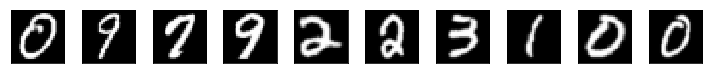

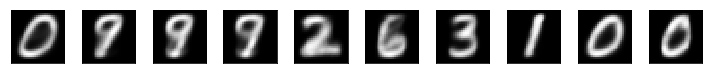

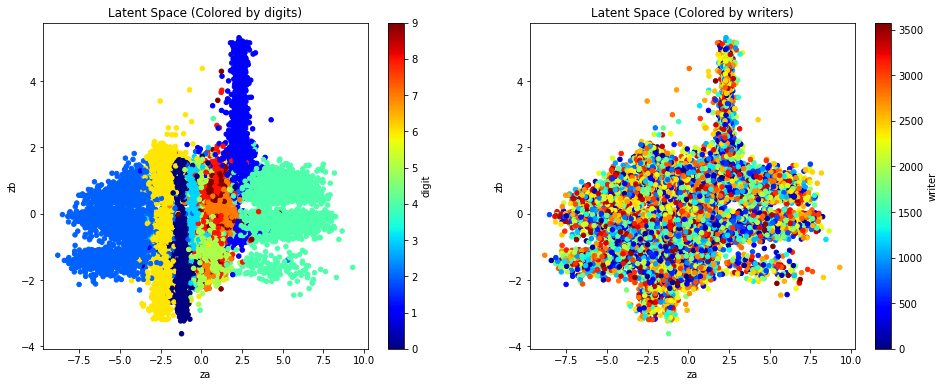

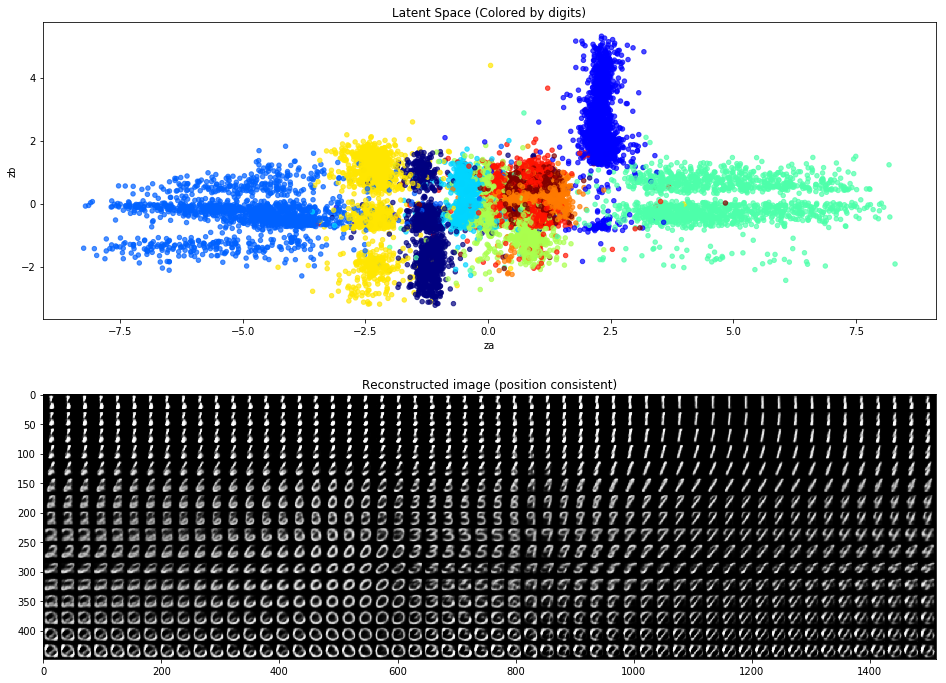

In [15]:
visualize_all(model)

### Save Model

In [16]:
description = {
    'Description': 'Double Latent Variational AutoEncoder + Classification(softmax)',
    'input': 'image (28*28 dim)',
    'output': 'reconstructed image (28*28 dim)',
    'batchsize': batchsize,
    'n_epoch': n_epoch,
    'n_latent': n_latent,
    'n_hidden': n_hidden,
}
save_model(model, 'model1', description)

## 5. ダブルボトルネック変分自己符号化器 + 識別器 + 共分散損失
## 5. Double Latent Variational AutoEncoder + Classification(softmax) + Covariance Loss

In [17]:
class WVAE_CLF_COR(chainer.Chain):
    """Variational AutoEncoder"""

    def __init__(self, n_in=784, n_latent=20, n_h=500):
        super(WVAE_CLF_COR, self).__init__()
        with self.init_scope():
            # encoder
            self.le1 = L.Linear(n_in, n_h)
            
            self.le2_mu_a = L.Linear(n_h, n_latent)
            self.le2_ln_var_a = L.Linear(n_h, n_latent)
            
            self.le2_mu_b = L.Linear(n_h, n_latent)
            self.le2_ln_var_b = L.Linear(n_h, n_latent)
            # decoder
            self.ld1_a = L.Linear(n_latent, n_h)
            self.ld1_b = L.Linear(n_latent, n_h)
            
            self.l_c = L.Linear(n_latent, n_labels)
            
            self.ld2 = L.Linear(n_h, n_in)

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        mu_a, sigma_a, mu_b, sigma_b = self.encode(x)
        return self.decode(mu_a, mu_b, sigmoid)
    
    def encode(self, x):
        h1 = F.tanh(self.le1(x))
        
        mu_a = self.le2_mu_a(h1)
        ln_var_a = self.le2_ln_var_a(h1)  # log(sigma**2)
        
        mu_b = self.le2_mu_b(h1)
        ln_var_b = self.le2_ln_var_b(h1)  # log(sigma**2)
        return mu_a, ln_var_a, mu_b, ln_var_b

    def decode(self, z_a, z_b, sigmoid=True):
        h1 = F.tanh(self.ld1_a(z_a)) + F.tanh(self.ld1_b(z_b))
        h2 = self.ld2(h1)
        if sigmoid:
            return F.sigmoid(h2)
        else:
            return h2

    def get_loss_func(self, C1=1.0, C2=100.0, C3=100.0, k=1):
        """Get loss function of VAE.
        The loss value is equal to ELBO (Evidence Lower Bound)
        multiplied by -1.
        Args:
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
        """
        def lf(args):
            x, t = args
            mu_a, ln_var_a, mu_b, ln_var_b = self.encode(x)
            batchsize = len(mu_a.data)
            # reconstruction loss
            rec_loss = 0
            clf_loss = 0
            dif_loss = 0
            for l in six.moves.range(k):
                z_a = F.gaussian(mu_a, ln_var_a)
                z_b = F.gaussian(mu_b, ln_var_b)
                rec_loss += F.bernoulli_nll(x, self.decode(z_a, z_b, sigmoid=False)) \
                    / (k * batchsize)
                clf_loss += C2 * F.softmax_cross_entropy(self.l_c(z_a), t)  \
                    / (k * batchsize)
                z_a_norm = F.normalize(z_a)
                z_b_norm = F.normalize(z_b)
                dif_loss += C3 * F.cross_covariance(z_a_norm, z_b_norm) \
                    / (k * batchsize)
            self.rec_loss = rec_loss
            self.clf_loss = clf_loss
            self.dif_loss = dif_loss
            self.loss = self.rec_loss + self.clf_loss + \
            C1 * (gaussian_kl_divergence(mu_a, ln_var_a) + \
                  gaussian_kl_divergence(mu_b, ln_var_b)) / batchsize
                
            return self.loss
        return lf

In [18]:
# print('GPU: {}'.format(args.gpu))
print('# dim z: {}'.format(n_latent))
print('# Minibatch-size: {}'.format(batchsize))
print('# epoch: {}'.format(n_epoch))
print('')

model = WVAE_CLF_COR(784, n_latent, n_hidden)

gpu_flag = 0

if gpu_flag >= 0:
    cuda.get_device_from_id(gpu_flag).use()
    model.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

# Setup optimizer
optimizer = optimizers.Adam(alpha=0.001)
optimizer.setup(model)

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch, end='  ')

    # training
    perm = np.random.permutation(N)
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    sum_clf_loss = 0
    for i in six.moves.range(0, N, batchsize):
        x = Variable(xp.asarray(x_train[perm[i:i + batchsize]]))
        t = Variable(xp.asarray(y_train[perm[i:i + batchsize]]))
        optimizer.update(model.get_loss_func(C2=C2, C3=C3), (x, t))

        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)

    print('train loss={:.4f}, rec loss={:.4f}, clf loss={:.4f}'
          .format(sum_loss/N, sum_rec_loss/N, sum_clf_loss/N), end=', ')

    # evaluation
    sum_loss = 0
    sum_rec_loss = 0
    sum_clf_loss = 0
    sum_dif_loss = 0
    with chainer.no_backprop_mode():
        for i in six.moves.range(0, N_test, batchsize):
            x = Variable(xp.asarray(x_test[i:i + batchsize]))
            t = Variable(xp.asarray(y_test[i:i + batchsize]))
            loss_func = model.get_loss_func(k=10, C1=C1, C2=C2, C3=C3)
            loss_func((x, t))
            sum_loss += float(model.loss.data) * len(x.data)
            sum_rec_loss += float(model.rec_loss.data) * len(x.data)
            sum_clf_loss += float(model.clf_loss.data) * len(x.data)
            sum_dif_loss += float(model.dif_loss.data) * len(x.data)
            del model.loss
    print('test  loss={:.4f}, rec loss={:.4f}, clf loss={:.4f}, dif loss={:.4f}'
          .format(sum_loss/N_test, sum_rec_loss/N_test,
                  sum_clf_loss/N_test, sum_dif_loss/N_test))

model.to_cpu()


# dim z: 1
# Minibatch-size: 256
# epoch: 50

epoch 1  train loss=308.0634, rec loss=234.5472, clf loss=0.0000, test  loss=289.5777, rec loss=223.3390, clf loss=59.0712, dif loss=0.0000
epoch 2  train loss=281.1643, rec loss=218.3093, clf loss=0.0000, test  loss=274.4716, rec loss=213.9410, clf loss=52.2128, dif loss=0.0090
epoch 3  train loss=270.4882, rec loss=211.7866, clf loss=0.0000, test  loss=266.7436, rec loss=209.5699, clf loss=48.2816, dif loss=0.0648
epoch 4  train loss=264.2321, rec loss=208.5602, clf loss=0.0000, test  loss=261.9741, rec loss=207.7970, clf loss=45.2743, dif loss=0.0919
epoch 5  train loss=259.7763, rec loss=206.5689, clf loss=0.0000, test  loss=258.3683, rec loss=206.1847, clf loss=43.0882, dif loss=0.1015
epoch 6  train loss=256.3023, rec loss=205.0644, clf loss=0.0000, test  loss=255.1544, rec loss=204.6633, clf loss=41.0911, dif loss=0.1707
epoch 7  train loss=253.4831, rec loss=203.9011, clf loss=0.0000, test  loss=253.2430, rec loss=204.4871, clf loss

### Visualizetion

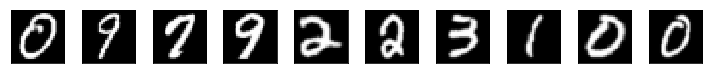

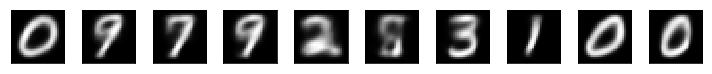

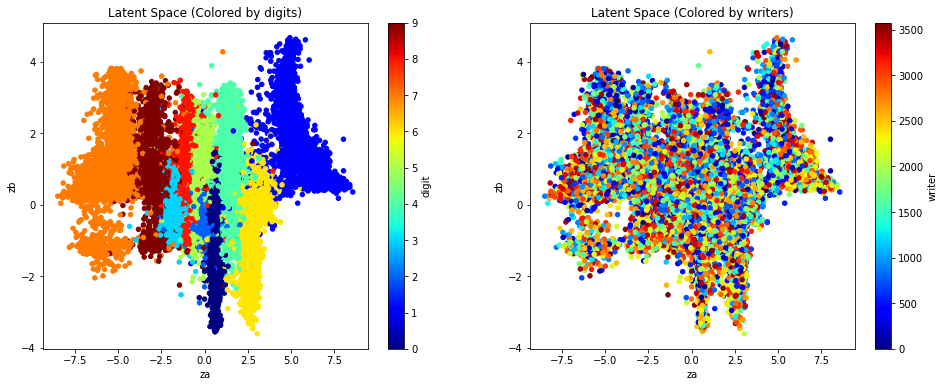

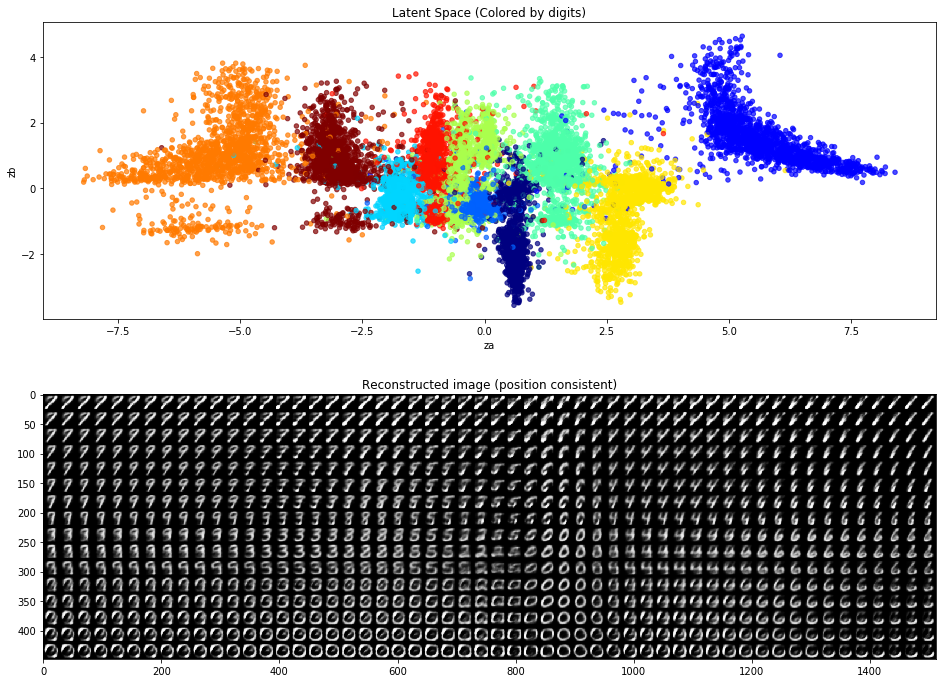

In [19]:
visualize_all(model)

### Save Model

In [20]:
description = {
    'Description': 'Double Latent Variational AutoEncoder + Classification(softmax) + Covariance Loss',
    'input': 'image (28*28 dim)',
    'output': 'reconstructed image (28*28 dim)',
    'batchsize': batchsize,
    'n_epoch': n_epoch,
    'n_latent': n_latent,
    'n_hidden': n_hidden,
}
save_model(model,'model2', description)

## （参考）識別器なし ダブルボトルネック変分自己符号化器
##  (Appendix) Double Latent Variational AutoEncoder without Classifier

In [21]:
class WVAE_NO_CLF(chainer.Chain):
    """Variational AutoEncoder"""

    def __init__(self, n_in=784, n_latent=20, n_h=500):
        super(WVAE_NO_CLF, self).__init__()
        with self.init_scope():
            # encoder
            self.le1 = L.Linear(n_in, n_h)
            
            self.le2_mu_a = L.Linear(n_h, n_latent)
            self.le2_ln_var_a = L.Linear(n_h, n_latent)
            
            self.le2_mu_b = L.Linear(n_h, n_latent)
            self.le2_ln_var_b = L.Linear(n_h, n_latent)
            # decoder
            self.ld1_a = L.Linear(n_latent, n_h)
            self.ld1_b = L.Linear(n_latent, n_h)
            
            self.ld2 = L.Linear(n_h, n_in)

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        mu_a, sigma_a, mu_b, sigma_b = self.encode(x)
        return self.decode(mu_a, mu_b, sigmoid)
    
    def encode(self, x):
        h1 = F.tanh(self.le1(x))
        
        mu_a = self.le2_mu_a(h1)
        ln_var_a = self.le2_ln_var_a(h1)  # log(sigma**2)
        
        mu_b = self.le2_mu_b(h1)
        ln_var_b = self.le2_ln_var_b(h1)  # log(sigma**2)
        return mu_a, ln_var_a, mu_b, ln_var_b

    def decode(self, z_a, z_b, sigmoid=True):
        h1 = F.tanh(self.ld1_a(z_a)) + F.tanh(self.ld1_b(z_b))
        h2 = self.ld2(h1)
        if sigmoid:
            return F.sigmoid(h2)
        else:
            return h2

    def get_loss_func(self, C=1.0, k=1):
        """Get loss function of VAE.
        The loss value is equal to ELBO (Evidence Lower Bound)
        multiplied by -1.
        Args:
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
        """
        def lf(x):
            mu_a, ln_var_a, mu_b, ln_var_b = self.encode(x)
            batchsize = len(mu_a.data)
            # reconstruction loss
            rec_loss = 0
            for l in range(k):
                z_a = F.gaussian(mu_a, ln_var_a)
                z_b = F.gaussian(mu_b, ln_var_b)
                rec_loss += F.bernoulli_nll(x, self.decode(z_a, z_b, sigmoid=False)) \
                    / (k * batchsize)
            self.rec_loss = rec_loss
            self.loss = self.rec_loss + \
            C * (gaussian_kl_divergence(mu_a, ln_var_a) + \
                 gaussian_kl_divergence(mu_b, ln_var_b)) / batchsize
            return self.loss
        return lf

In [22]:
print('# dim z: {}'.format(n_latent))
print('# Minibatch-size: {}'.format(batchsize))
print('# epoch: {}'.format(n_epoch))
print('')

model = WVAE_NO_CLF(784, n_latent, n_hidden)

gpu_flag = 0

if gpu_flag >= 0:
    cuda.get_device_from_id(gpu_flag).use()
    model.to_gpu()

xp = np if gpu_flag < 0 else cuda.cupy

# Setup optimizer
optimizer = optimizers.Adam(alpha=0.001)
optimizer.setup(model)

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch, end='  ')

    # training
    perm = np.random.permutation(N)
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    for i in six.moves.range(0, N, batchsize):
        x = Variable(xp.asarray(x_train[perm[i:i + batchsize]]))
        optimizer.update(model.get_loss_func(), x)

        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)

    print('train loss={:.4f}, rec loss={:.4f}'
          .format(sum_loss / N, sum_rec_loss / N), end=', ')

    # evaluation
    sum_loss = 0
    sum_rec_loss = 0
    with chainer.no_backprop_mode():
        for i in range(0, N_test, batchsize):
            x = Variable(xp.asarray(x_test[i:i + batchsize]))
            loss_func = model.get_loss_func(k=10)
            loss_func(x)
            sum_loss += float(model.loss.data) * len(x.data)
            sum_rec_loss += float(model.rec_loss.data) * len(x.data)
            del model.loss
    print('test  loss={:.4f}, rec loss={:.4f}'
          .format(sum_loss / N_test, sum_rec_loss / N_test))


model.to_cpu()


# dim z: 1
# Minibatch-size: 256
# epoch: 50

epoch 1  train loss=238.5577, rec loss=233.1672, test  loss=229.0568, rec loss=223.6341
epoch 2  train loss=225.8967, rec loss=220.4240, test  loss=223.0520, rec loss=217.4784
epoch 3  train loss=220.3811, rec loss=214.7481, test  loss=218.5592, rec loss=212.7994
epoch 4  train loss=216.8872, rec loss=211.0655, test  loss=215.9894, rec loss=210.1670
epoch 5  train loss=214.1659, rec loss=208.1976, test  loss=212.8284, rec loss=206.6820
epoch 6  train loss=211.6461, rec loss=205.5521, test  loss=210.6461, rec loss=204.4718
epoch 7  train loss=209.7927, rec loss=203.5664, test  loss=209.2532, rec loss=202.9874
epoch 8  train loss=208.4684, rec loss=202.1678, test  loss=208.5367, rec loss=202.2406
epoch 9  train loss=207.4317, rec loss=201.0722, test  loss=207.4671, rec loss=201.1106
epoch 10  train loss=206.6974, rec loss=200.2893, test  loss=206.2523, rec loss=199.8086
epoch 11  train loss=206.0610, rec loss=199.6068, test  loss=205.8565, re

### Visualization

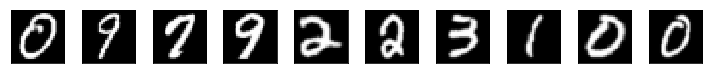

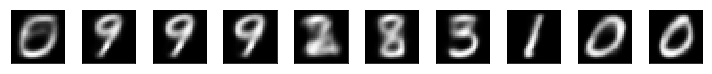

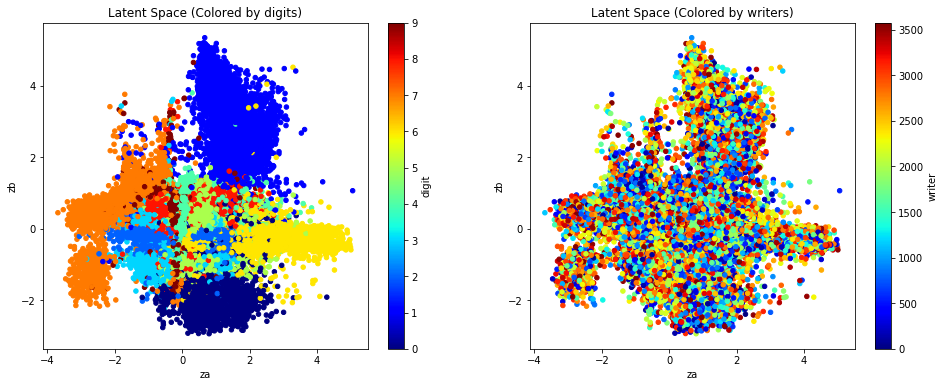

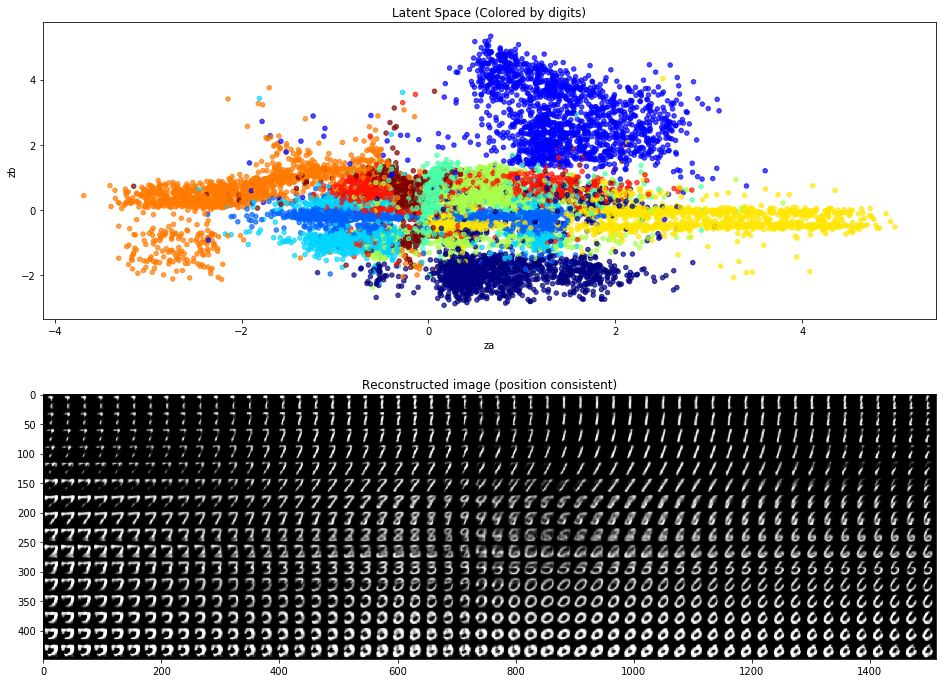

In [23]:
visualize_all(model)

### Save Model

In [24]:
description = {
    'Description': 'Double Latent Variational AutoEncoder without Classifier',
    'input': 'image (28*28 dim)',
    'output': 'reconstructed image (28*28 dim)',
    'batchsize': batchsize,
    'n_epoch': n_epoch,
    'n_latent': n_latent,
    'n_hidden': n_hidden,
}
save_model(model,'model3', description)